In [1]:
import datetime

import torch

from cogment_lab.envs.gymnasium import GymEnvironment
from cogment_lab.envs.pettingzoo import ParallelEnvironment
from cogment_lab.process_manager import Cogment
from cogment_lab.utils.coltra_utils import convert_trial_data_to_coltra
from cogment_lab.utils.runners import process_cleanup
from cogment_lab.utils.trial_utils import concatenate

from coltra import HomogeneousGroup
from coltra.buffers import Observation
from coltra.models import MLPModel
from coltra.policy_optimization import CrowdPPOptimizer

from cogment_lab.actors.nn_actor import ColtraActor

from tqdm import trange
import matplotlib.pyplot as plt


In [2]:
logpath = f"logs/logs-{datetime.datetime.now().isoformat()}"

cog = Cogment(log_dir=logpath)

print(logpath) 

logs/logs-2024-02-16T23:24:12.885158


In [3]:
# Launch an environment in a subprocess

cenv = ParallelEnvironment(env_path="pettingzoo.butterfly.cooperative_pong_v5.parallel_env",
                      render=True,
                           make_kwargs={"bounce_randomness": True, "cake_paddle": False})

# cenv = ParallelEnvironment(env_path="utils.PongEnv",
#                       render=False)

await cog.run_env(env=cenv, 
                  env_name="pong",
                  port=9011, 
                  log_file="env.log")


True

In [4]:
cenv.env.action_space("paddle_0")

Discrete(3)

In [5]:
from coltra.envs.spaces import ObservationSpace
import numpy as np
from coltra import DAgent, CAgent, Observation
from cogment_lab.core import CogmentActor
from cogment_lab.actors.nn_actor import ColtraActor
from coltra.models import MLPModel, BaseModel, ImageMLPModel

from utils import ColtraImageActor, FloatImageMLPModel

# Create a model using coltra

model = FloatImageMLPModel(
    config={
    "hidden_sizes": [64, 64],
    }, 
    observation_space=ObservationSpace(image=cenv.env.observation_space("paddle_0")), 
    action_space=cenv.env.action_space("paddle_0")
)

# Put the model in shared memory so that the actor can access it
model.share_memory()
actor = ColtraImageActor(model=model)


await cog.run_actor(
    actor=actor,
    actor_name="coltra",
    port=9021,
    log_file="actor.log"
)

True

In [6]:
cog.processes

{'pong': <SpawnProcess name='cogment_lab_pong' pid=12079 parent=12071 started>,
 'coltra': <SpawnProcess name='cogment_lab_coltra' pid=12087 parent=12071 started>}

In [7]:
ppo = CrowdPPOptimizer(HomogeneousGroup(actor.agent), config={
    "gae_lambda": 0.95,
    "minibatch_size": 128,
})

In [8]:
all_rewards = []

for t in (pbar := trange(2_000)):
    num_steps = 0
    episodes = []

    trial_id = await cog.start_trial(
        env_name="pong",
        session_config={"render": False},
        actor_impls={
            "paddle_0": "coltra",
            "paddle_1": "coltra"
        },
    )
    multi_data = await cog.get_trial_data(trial_id=trial_id, env_name="pong")
    # data = multi_data["gym"]
        
    all_data = concatenate([multi_data["paddle_0"], multi_data["paddle_1"]])
    all_data.observations = all_data.observations.reshape(all_data.observations.shape[0], -1).astype(np.float32) / 255.
    all_data.last_observation = all_data.last_observation.reshape(all_data.last_observation.shape[0], -1).astype(np.float32) / 255.

    # Preprocess data
    record = convert_trial_data_to_coltra(all_data, actor.agent)

    # Run a PPO step
    metrics = ppo.train_on_data({"crowd": record}, shape=(1,) + record.reward.shape)
    
    mean_reward = metrics["crowd/mean_episode_reward"]
    all_rewards.append(mean_reward)
    pbar.set_description(f"mean_reward: {mean_reward:.3}")
    
    if t % 100 == 0:
      state_dict = model.state_dict()
      torch.save(state_dict, f"models/model_{t}.pth")

mean_reward: 57.7:  70%|██████▉   | 1391/2000 [4:37:09<2:01:20, 11.96s/it] 


ValueError: No samples provided

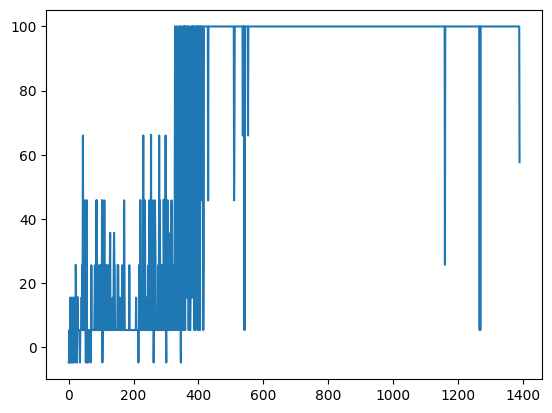

In [9]:
plt.plot(all_rewards)

In [11]:
import torch

torch.save(model.state_dict(), "model.pth")

In [10]:
import torch

state_dict = torch.load("models/model_1000.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
PONG_ACTIONS = ["no-op", "ArrowUp", "ArrowDown"]

actions = PONG_ACTIONS
await cog.run_web_ui(actions=actions, log_file="human.log", fps=30)

True

In [34]:
trial_id = await cog.start_trial(
    env_name="pong",
    session_config={"render": True},
    actor_impls={
        "paddle_0": "coltra",
        "paddle_1": "web_ui",
    },
)

data = await cog.get_trial_data(trial_id)


ValueError: No samples provided